In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import koreanize_matplotlib
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression , LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import auc, roc_curve, roc_auc_score , accuracy_score, mean_squared_error, f1_score

from scipy.stats import stats 
from scipy.stats import chi2_contingency, ttest_ind

## 머신러닝1
문제문의 datamanim@gmail.com

데이터 : 급성심장정지조사 데이터 후처리 (2019,2020)    
출처 : https://mdis.kostat.go.kr/ (기관으로부터 본 교육자료 외 2차 가공 및 배포 불가능하다는 답변 받았습니다.)


m1.csv : 성별,연령에 따른 급성심장정지 발생에 대한 조사 데이터    
m1_index.csv : 각 응답에 따른 대응값에 대한 정보    


종속변수 :응급실 심폐소생술 후 자발순환 회복 여부


In [2]:
import pandas as pd
df  = pd.read_csv('C:/Users/i2max-DoeunKim/adps/EP_1/m1.csv', encoding='utf-8-sig')
idx = pd.read_csv('C:/Users/i2max-DoeunKim/adps/EP_1/m1_index.csv', encoding='utf-8-sig')

display(df.head())
idx.head()

,성별,연령,병원 도착 전 자발순환 회복 여부,병원 도착 전 급성심장정지 목격 여부,목격자유형1,목격자유형2,일반인 심폐소생술 시행여부,발생장소_공공장소,발생장소_비공공장소,급성심장정지 발생 당시 활동,발생원인_질병,발생원인_질병외,응급실 심폐소생술 후 자발순환 회복 여부,응급실 제세동 실시 여부,환자 발생장소_시도
0,1,0,2,1,NaN,3.0,2,NaN,1.0,7,1.0,NaN,1.0,1,서울
1,1,0,2,1,NaN,3.0,2,NaN,1.0,7,1.0,NaN,2.0,1,경기
2,1,0,2,1,NaN,3.0,2,NaN,1.0,7,5.0,NaN,1.0,1,경기
3,1,0,2,1,NaN,3.0,2,NaN,1.0,7,5.0,NaN,1.0,1,경기
4,1,0,2,1,NaN,3.0,2,NaN,1.0,7,5.0,NaN,1.0,1,경기


,변수,값,의미
0,성별,1,남자
1,성별,2,여자
2,병원 도착 전 자발순환 회복 여부,1,자발순환 회복
3,병원 도착 전 자발순환 회복 여부,2,자발순환 회복 없음
4,병원 도착 전 급성심장정지 목격 여부,1,목격되지 않음


머신러닝 1-1     
아래 기준에 따라 전처리를 시행하라
1. m1_index.csv를 바탕으로 조사 데이터의 값들을 모두 대응값으로 변경하라.
2. 3쌍의 컬럼을 각각 한쌍의 컬럼으로 통합컬럼들을 추가하고 6개의 컬럼은 제거하라
    - `목격자` 컬럼생성 : 목격자유형1과 목격자유형2 컬럼을 결측치가 존재하는 부분을 고려하여 서로 합친다. 
    - `발생장소` 컬럼생성 : 발생장소_공공장소과 발생장소_비공공장소 컬럼을 결측치가 존재하는 부분을 고려하여 서로 합친다. 
    - `발생원인` 컬럼생성 : 발생원인_질병과 발생원인_질병외 컬럼을 결측치가 존재하는 부분을 고려하여 서로 합친다. 


In [3]:
# idx 처리 

# 변수의 값마다 
map_dic = {}
for name in idx['변수'].unique() : 
    target = idx[idx['변수'] == name] 

    key_value = {}
    for key, value in target.iloc[:,1:].values : 
        key_value[key] = value 
    map_dic[name] = key_value 

In [4]:
for col in df.columns: 
    if col in map_dic.keys() :
        df[col] = df[col].map(map_dic[col])
    else : 
        df[col] = df[col].map(lambda x : x)

df.head(4)
df['응급실 심폐소생술 후 자발순환 회복 여부'].value_counts()

응급실 심폐소생술 후 자발순환 회복 여부
자발순환 회복됨    4632
회복되지 않음     4373
Name: count, dtype: int64

In [5]:
df['발생장소_공공장소'].value_counts()

발생장소_공공장소
상업시설       457
도로/고속도로    194
산업시설       184
여가관련 장소     60
공공건물        42
터미널         27
Name: count, dtype: int64

In [6]:
#목격자 컬럼생성 : 목격자유형1과 목격자유형2 컬럼을 결측치가 존재하는 부분을 고려하여 서로 합친다.
#발생장소 컬럼생성 : 발생장소_공공장소과 발생장소_비공공장소 컬럼을 결측치가 존재하는 부분을 고려하여 서로 합친다.
#발생원인 컬럼생성 : 발생원인_질병과 발생원인_질병외 컬럼을 결측치가 존재하는 부분을 고려하여 서로 합친다.


df['목격자'] = df[['목격자유형1','목격자유형2']].apply(lambda x : x['목격자유형1'] if pd.isna(x['목격자유형2']) else x['목격자유형2'] , axis = 1)
df['발생장소'] = df[['발생장소_공공장소','발생장소_비공공장소']].apply(lambda x : x['발생장소_공공장소'] if pd.isna(x['발생장소_비공공장소']) else x['발생장소_비공공장소'], axis = 1)
df['발생원인'] = df[['발생원인_질병','발생원인_질병외']].apply(lambda x: x['발생원인_질병외'] if pd.isna(x['발생원인_질병']) else x['발생원인_질병'], axis = 1)

pre_df = df.drop(columns = ['목격자유형1','목격자유형2', '발생장소_공공장소','발생장소_비공공장소' ,'발생원인_질병','발생원인_질병외'], axis = 1)
pre_df.head(3)

,성별,연령,병원 도착 전 자발순환 회복 여부,병원 도착 전 급성심장정지 목격 여부,일반인 심폐소생술 시행여부,급성심장정지 발생 당시 활동,응급실 심폐소생술 후 자발순환 회복 여부,응급실 제세동 실시 여부,환자 발생장소_시도,목격자,발생장소,발생원인
0,남자,0,자발순환 회복 없음,목격되지 않음,시행함,일상생활 중,회복되지 않음,실시하지 않음,서울,가족,집,심인성
1,남자,0,자발순환 회복 없음,목격되지 않음,시행함,일상생활 중,자발순환 회복됨,실시하지 않음,경기,가족,집,심인성
2,남자,0,자발순환 회복 없음,목격되지 않음,시행함,일상생활 중,회복되지 않음,실시하지 않음,경기,가족,집,영아돌연사증후군


머신러닝 1-2      
데이터 EDA를 실시하라(시각화 포함)

Index(['성별', '연령', '병원 도착 전 자발순환 회복 여부', '병원 도착 전 급성심장정지 목격 여부',
       '일반인 심폐소생술 시행여부', '급성심장정지 발생 당시 활동', '응급실 제세동 실시 여부', '환자 발생장소_시도',
       '목격자', '발생장소', '발생원인'],
      dtype='object')


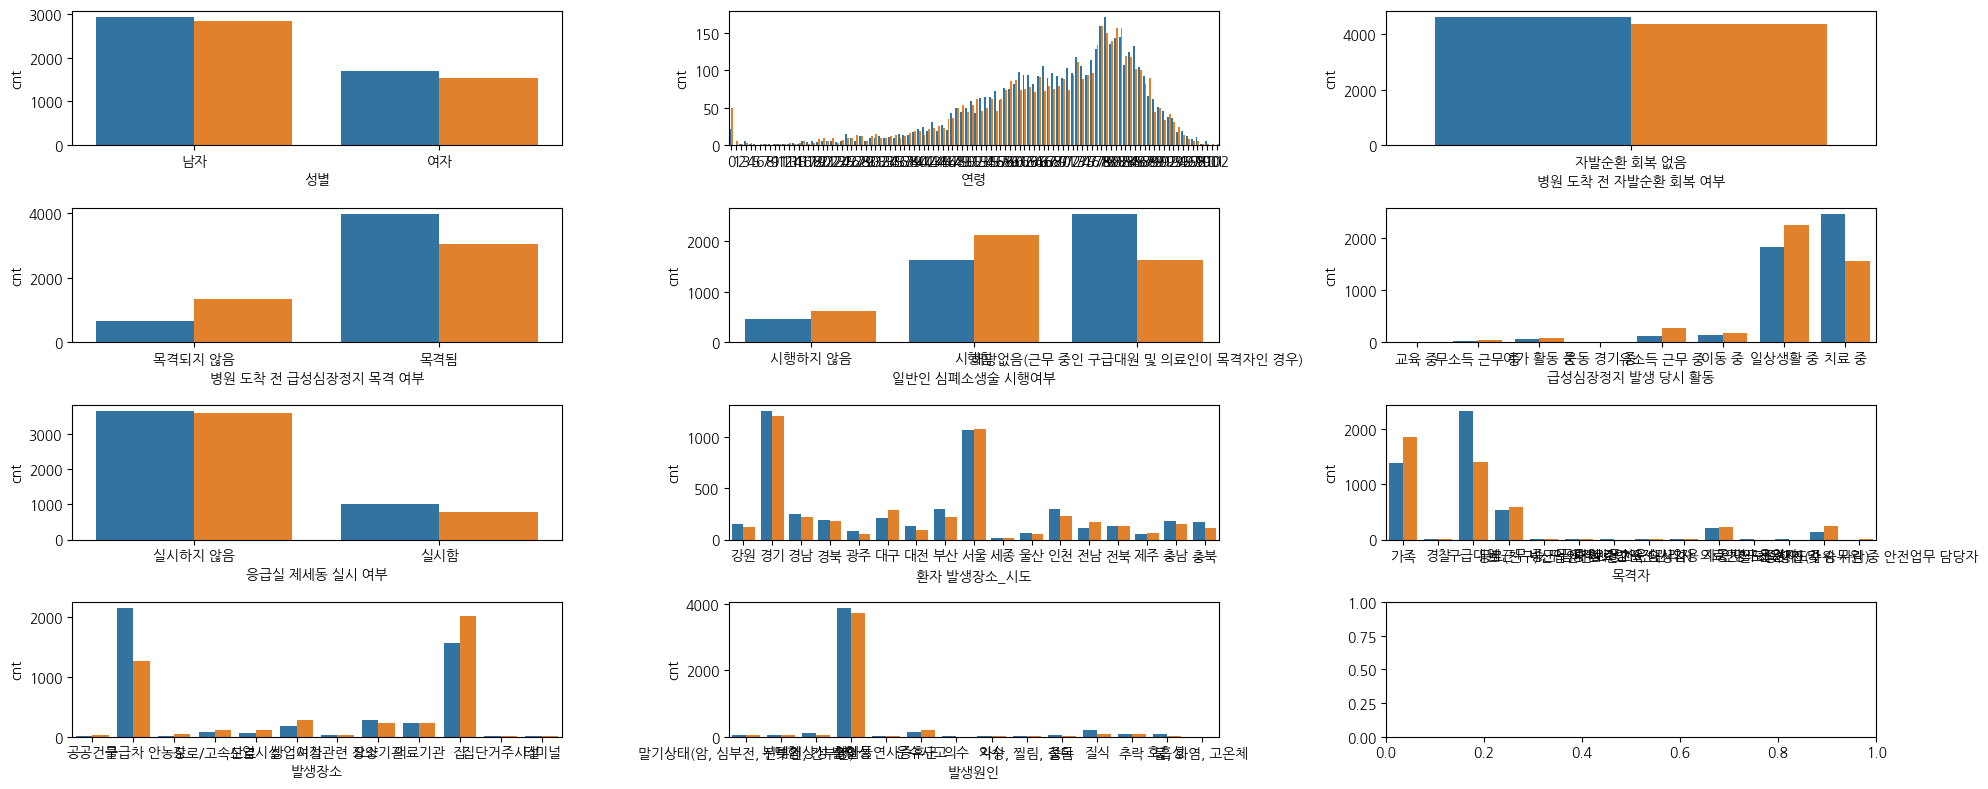

In [7]:
# 종속변수 :응급실 심폐소생술 후 자발순환 회복 여부

target_col = pre_df.drop(columns = '응급실 심폐소생술 후 자발순환 회복 여부' , axis = 1).columns 
print(target_col)
y_value = '응급실 심폐소생술 후 자발순환 회복 여부'

fig, axes = plt.subplots(4,3, figsize = (20, 8)) 
for axes, col in zip(axes.flatten() , target_col) : 
    t = df.groupby([y_value ,col]).size().reset_index(name = 'cnt')
    sns.barplot(x = col, y = "cnt" , hue = y_value , data = t, ax = axes)
    axes.legend().remove()

plt.tight_layout()
plt.show()
 

머신러닝 1-3     
종속변수(응급실 심폐소생술 후 자발순환 회복 여부)와 각 독립변수들간의 통계적인 차이가 있는지 검정하라

In [8]:
y = '응급실 심폐소생술 후 자발순환 회복 여부' 

categorical_cols = ['성별','병원 도착 전 자발순환 회복 여부','병원 도착 전 급성심장정지 목격 여부',
                    '일반인 심폐소생술 시행여부','급성심장정지 발생 당시 활동','응급실 제세동 실시 여부',
                    '환자 발생장소_시도','목격자','발생장소','발생원인'] 

res = []
for col in pre_df.columns : 
    if pre_df[col].dtypes == 'object' : 
        tab = pd.crosstab(pre_df[col] , pre_df[y])
        stat, p_val, _, _ = chi2_contingency(tab) 
        
    else : 
        g = pre_df.groupby(y)[col].apply(list)
        stats, p_val = stats.ttest_ind(g[0], g[1])

    decision = '유의하다' if p_val < 0.05 else '유의하지않다' 
    res.append({
        'Col' : col, 
        'p_value' : p_val, 
        'Decision' : decision
    })
            
pd.DataFrame(res)         


,Col,p_value,Decision
0,성별,8.548896e-02,유의하지않다
1,연령,5.354918e-02,유의하지않다
2,병원 도착 전 자발순환 회복 여부,1.000000e+00,유의하지않다
3,병원 도착 전 급성심장정지 목격 여부,1.019208e-76,유의하다
4,일반인 심폐소생술 시행여부,1.118404e-60,유의하다
5,급성심장정지 발생 당시 활동,3.399277e-63,유의하다
6,응급실 심폐소생술 후 자발순환 회복 여부,0.000000e+00,유의하다
7,응급실 제세동 실시 여부,2.264996e-05,유의하다
8,환자 발생장소_시도,3.618110e-08,유의하다
9,목격자,3.846845e-63,유의하다


머신러닝 1-4      
종속변수를 예측하는 분류모델을 2개 선정 하려한다.(평가지표 auc)    
모델을 선정하고 모델 특성에 맞게 여러 범주형 변수를 적절하게 인코딩하는 방법에 대해 논하라.

머신러닝 1-5     
두 개의 분류모델을 선택하여 학습하고 모델 평가를 진행하라. 데이터 분할 및 모델 학습은 다음과 같은 기준으로 진행한다.     
1. 데이터의 행의 인덱스(0부터시작)을 기준으로 7로 나눈 나머지가 0 또는 3이면 test, 그렇지 않으면 train으로 한다.
2. 전처리는 train data에 우선 실시하고 train data에서 했던 전처리 기준으로 test data에도 적용한다.
3. 모델 학습 및 결과 분석을 진행하라

응급실 심폐소생술 후 자발순환 회복 여부
1    4632
0    4373
Name: count, dtype: int64


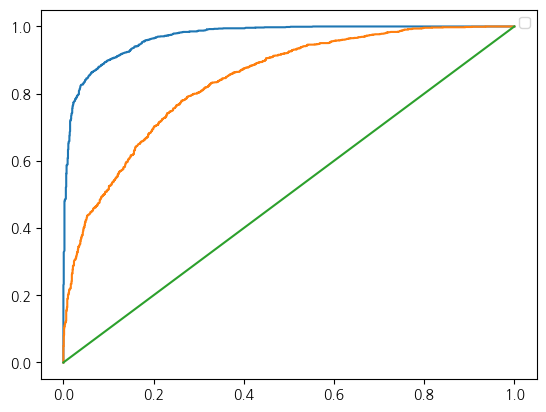

In [9]:
# 차원이 너무 커지기 떄문에 ONe-Hot Encoding으로 처리 

one_hot_df = pd.DataFrame()
for col in pre_df.columns : 
    if col not in ['연령', '응급실 심폐소생술 후 자발순환 회복 여부'] : 
        encoder = LabelEncoder()
        one_hot_df[col] = encoder.fit_transform(pre_df[col]) 
    elif col == '연령' : 
        one_hot_df[col] = pre_df[col]
    else : 
        one_hot_df[col] = pre_df[col].map({'자발순환 회복됨' : 1, '회복되지 않음' : 0}).astype(int)


# 데이터 분리 
train = one_hot_df[(one_hot_df.index %7 !=0) | (one_hot_df.index % 7 != 3)]
x_train = train.drop(columns = '응급실 심폐소생술 후 자발순환 회복 여부' , axis = 1)
y_train = train['응급실 심폐소생술 후 자발순환 회복 여부']
print(y_train.value_counts())

test = one_hot_df[(one_hot_df.index %7 ==0) | (one_hot_df.index % 7 == 3)]
x_test = test.drop(columns = '응급실 심폐소생술 후 자발순환 회복 여부' , axis = 1)
y_test = test['응급실 심폐소생술 후 자발순환 회복 여부'] 


def eval_model(name, model, x_train, x_test, y_train, y_test) : 
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    f1 = f1_score(y_test, pred)
    accuracy = accuracy_score(y_test, pred)

    pred_proba = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, pred_proba)

    fpr, tpr, _ = roc_curve(y_test, pred_proba)
    plt.plot(fpr, tpr)

    return f1, accuracy 


res = []
model_lst = []
for name, model in [['RF', RandomForestClassifier()] , ['xgb', xgb.XGBClassifier()]] : 
    f1, accuracy = eval_model(name, model, x_train, x_test, y_train, y_test)
    res.append([name, f1, accuracy])
    model_lst.append([name, model])

plt.plot([0,1],[0,1])
plt.legend()
plt.show()

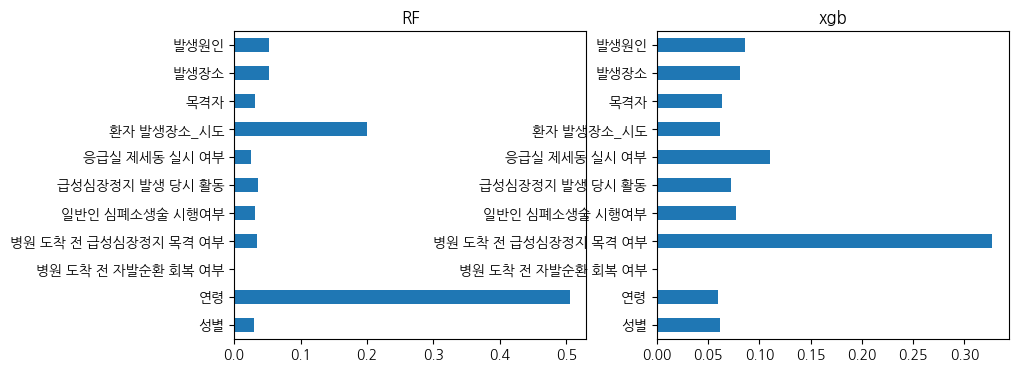

In [10]:
fig, axes = plt.subplots(1,2, figsize = (10, 4))

for axes, (name, model) in zip(axes, model_lst) :
    f = model.feature_importances_
    x = model.feature_names_in_
    imp = pd.Series(f, index =x)
    imp.plot.barh(ax = axes)
    axes.set_title(f"{name}")

통계1-1    
세 마케팅 전략 간 판매량에 유의미한 차이가 있는지 분산분석을 실시하시오. 
귀무가설과 대립가설을 명확히 설정하고, 통계량에 따른 적절한 검정을 수행하시오.

In [11]:
df  = pd.read_csv('C:/Users/i2max-DoeunKim/adps/EP_1/s1.csv')
df.head()

,마케팅전략,판매량,만족도
0,A,524.84,8.8
1,A,493.09,8.2
2,A,532.38,8.0
3,A,576.15,9.0
4,A,488.29,9.3


In [12]:
from scipy.stats import shapiro, levene, kruskal

# 1. 정규성 
# 정규분포이다 p < a 기각 OK  
res =[]
for key, group in df.groupby(['마케팅전략']) :
    stat, pval = shapiro(group['판매량'])
    decision = '정규성 위배' if pval < 0.05 else '정규성 만족'

    res.append([key, pval, decision])

# 2. 등분산성 
g = [group['판매량'] for name, group in df.groupby('마케팅전략')]
stats, p_val = levene(* g)
print(p_val)
print('등분산이다' if p_val < 0.05 else '등분산이 아니다')
print(pd.DataFrame(res, columns = ['col','p_value','decision']))



5.452407609077732e-10
등분산이다
    col   p_value decision
0  (A,)  0.672051   정규성 만족
1  (B,)  0.453425   정규성 만족
2  (C,)  0.091206   정규성 만족


             df        sum_sq       mean_sq           F        PR(>F)
C(마케팅전략)    2.0  2.129378e+06  1.064689e+06  235.495903  1.447420e-46
Residual  147.0  6.645944e+05  4.521050e+03         NaN           NaN
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj   lower     upper   reject
--------------------------------------------------------
     A      B  157.3444   0.0  125.5042  189.1846   True
     A      C -134.1972   0.0 -166.0374  -102.357   True
     B      C -291.5416   0.0 -323.3818 -259.7014   True
--------------------------------------------------------


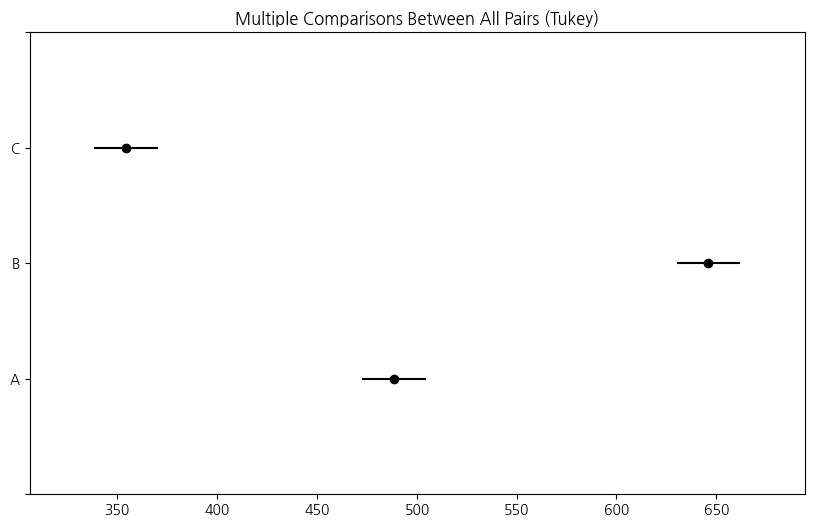

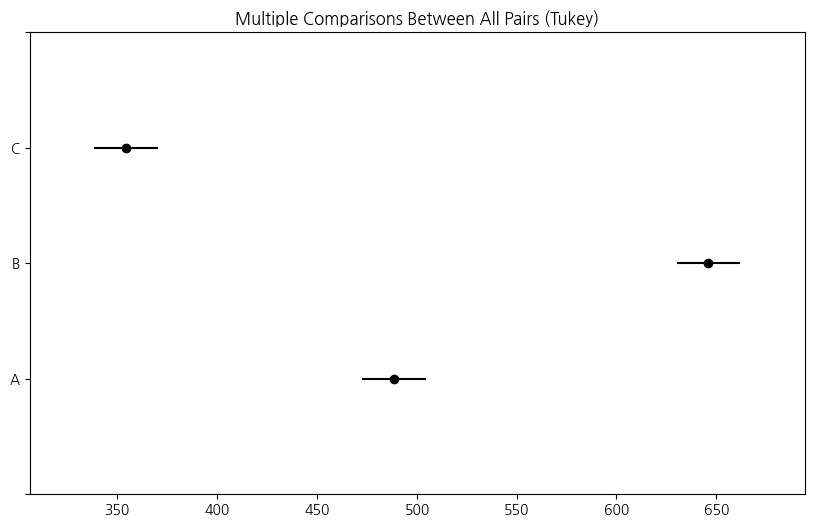

In [14]:
import statsmodels.api as sm 
from statsmodels.formula.api import ols 
from statsmodels.stats.multicomp import pairwise_tukeyhsd

model = ols('판매량 ~ C(마케팅전략)', data = df).fit()
anova_t = sm.stats.anova_lm(model)
print(anova_t)

# 사후검정 
tukey = pairwise_tukeyhsd(endog = df['판매량'], groups = df['마케팅전략'] , alpha=0.05)
print(tukey)

tukey.plot_simultaneous()

통계1-2    
필요에 따라 사후검정을 실시하여 어떤 전략 간에 유의한 차이가 있는지 확인하시오. 
박스플롯을 활용하여 시각적으로 마케팅 전략별 판매량 차이를 표현하시오.

3.0448226717402373e-27
              A             B             C
A  1.000000e+00  6.793820e-07  1.318722e-09
B  6.793820e-07  1.000000e+00  2.670505e-28
C  1.318722e-09  2.670505e-28  1.000000e+00


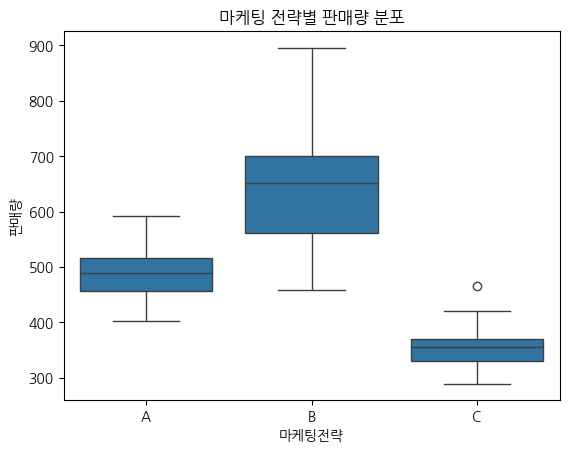


dunn 으로 검정한 결과, A,B,C에 따라 판매량 차이가 유의하다고 나타나며, 이를 박스 플롯의 형태로 
보여준다. 이는 각 마케팅에 따라 판매량이 다르기 때문에, 마케팅 별 전략별 효과 분석이 필요해보인다. 



In [15]:
# 3) 비모수 검정 : Anova의 비모수 - Kruskal-Wallis 
stat, p_val = kruskal(* [ group['판매량'].values for name, group in df.groupby(['마케팅전략'])])
print(p_val)


import scikit_posthocs as sp
print(sp.posthoc_dunn(df, val_col='판매량', group_col='마케팅전략'))

sns.boxplot(data=df, x='마케팅전략', y='판매량')
plt.title("마케팅 전략별 판매량 분포")
plt.show()

print('''
dunn 으로 검정한 결과, A,B,C에 따라 판매량 차이가 유의하다고 나타나며, 이를 박스 플롯의 형태로 
보여준다. 이는 각 마케팅에 따라 판매량이 다르기 때문에, 마케팅 별 전략별 효과 분석이 필요해보인다. 
''')

문제문의 datamanim@gmail.com